## Artigo 1

A proposta desse arquivo é desenvolver uma técnica que permite otmizar a seleção de vértices e arestas de suporte.

A ideia é usar um classificador de baixa capacidade e, consequentemente, fácil de treinar para selecionar uma porção da amostra que será canditada a compor o novo classificador.

Será baseado em classificadores de grafo de gabriel.

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import gg
from scipy.spatial import Delaunay

In [128]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(X, y, title):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[y==-1][:,0], X[y==-1][:,1], c='red', label="Classe 0")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c='blue', label="Classe 1")
    plt.title(title)
    plt.legend()
    plt.show()


def generate_separated_sines(n=200, x_min=0, x_max=4*np.pi, shift=1.5, noise_sigma=0.1, seed=0):
    """
    Gera duas curvas senoidais deslocadas verticalmente de forma que não se encostem.
    Retorna: X (2n x 2) com colunas [x, y], e y_labels (2n,) {0,1}.
    """
    rng = np.random.RandomState(seed)
    x = rng.uniform(x_min, x_max, size=n)
    x = np.sort(x)

    # Curvas deslocadas
    y_upper = np.sin(x) + shift + rng.normal(0, noise_sigma, size=n)
    y_lower = np.sin(x) - shift + rng.normal(0, noise_sigma, size=n)
    
    # Empilha em formato (x, y)
    X_upper = np.column_stack([x, y_upper])
    X_lower = np.column_stack([x, y_lower])
    
    X = np.vstack([X_upper, X_lower])
    labels = np.hstack([-1*np.ones(n), np.ones(n)])  # 1 = superior, 0 = inferior
    return X, labels


# 1. Distribuição em duas nuvens gaussianas
def gaussian_blobs(n=100):
    X0 = np.random.randn(n, 2) + np.array([-2, -2])
    X1 = np.random.randn(n, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

# 2. Dados em duas faixas paralelas
def parallel_stripes(n=100):
    X0 = np.random.rand(n, 2) * 2 + np.array([0, 0])
    X1 = np.random.rand(n, 2) * 2 + np.array([3, 0])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

# 3. Dados separados por uma diagonal
def diagonal_split(n=200):
    X = np.random.uniform(-3, 3, size=(n, 2))
    y = (X[:,0] + X[:,1] > 0).astype(int)  # separação por reta diagonal
    return X, y

# 4. Duas classes em quadrados deslocados
def squares(n=100):
    X0 = np.random.rand(n, 2) + np.array([0, 0])
    X1 = np.random.rand(n, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y




In [129]:
x, y = parallel_stripes(n = 100)

In [130]:
def train_perceptron(X, y, lr=0.01, epochs=100, bias=True):
    if bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Adiciona o termo de bias como coluna
    # Inicializa pesos uniformemente entre -0.5 e 0.5
    weights = np.random.uniform(-0.5, 0.5, X.shape[1])
    for epoch in range(epochs):
        error = 0
        # Aleatoriza os índices
        indices = np.random.permutation(X.shape[0])
        for i in indices:
            # Calcula a ativação
            activation = np.dot(weights, X[i])
            # Atualiza os pesos se houver erro
            if y[i] * activation <= 0:
                weights += lr * y[i] * X[i]
                error += 1
        error_rate = error / X.shape[0]
        print(f'Epoch {epoch+1}/{epochs}, Error Rate: {error_rate:.4f}')
    return weights
        

Epoch 1/10, Error Rate: 0.0900
Epoch 2/10, Error Rate: 0.0600
Epoch 3/10, Error Rate: 0.0100
Epoch 4/10, Error Rate: 0.0000
Epoch 5/10, Error Rate: 0.0000
Epoch 6/10, Error Rate: 0.0000
Epoch 7/10, Error Rate: 0.0000
Epoch 8/10, Error Rate: 0.0000
Epoch 9/10, Error Rate: 0.0000
Epoch 10/10, Error Rate: 0.0000


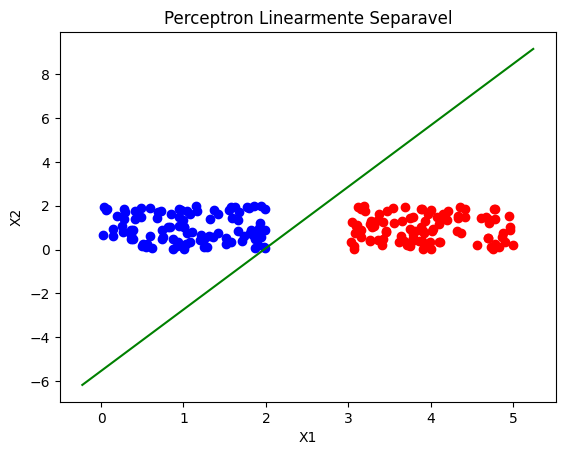

In [131]:
pesos = train_perceptron(x,y,lr=0.1,epochs=10)
#Plota o separador linear sem meshgrid, só desenha a linha mesmo
plt.scatter(x[y==-1][:, 0], x[y==-1][:, 1], color="blue", label="Class 0")
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], color='red', label='Classe 1')
plt.xlabel('X1')    
plt.ylabel('X2')
plt.title('Perceptron Linearmente Separavel') 
x_vals = np.array(plt.gca().get_xlim())
y_vals = -(pesos[0] + pesos[1] * x_vals) / pesos[2]
plt.plot(x_vals, y_vals, color='green', label='Separador Linear')
plt.show()

In [132]:
#Seleciona a partir do perceptron k% de cada classe dos pontos mais próximos da margem

def select_closest_to_margin(X, y, weights, k=0.2, bias=True):
    if bias:
        X = np.hstack([np.ones((X.shape[0], 1)), X])  # Adiciona o termo de bias como coluna
    # Separa o conjunto de dados por classe
    class_0_indices = np.where(y == -1)[0]
    class_1_indices = np.where(y == 1)[0]
    class_0_points = X[class_0_indices]
    class_1_points = X[class_1_indices]
    # Calcula as distâncias à margem para cada ponto
    distances_0 = np.abs(np.dot(class_0_points, weights)) / np.linalg.norm(weights[1:])
    distances_1 = np.abs(np.dot(class_1_points, weights)) / np.linalg.norm(weights[1:])
    # Seleciona os k% mais próximos da margem em cada classe
    num_select_0 = max(1, int(len(class_0_points) * k))
    num_select_1 = max(1, int(len(class_1_points) * k))
    selected_indices_0 = class_0_indices[np.argsort(distances_0)[:num_select_0]]
    selected_indices_1 = class_1_indices[np.argsort(distances_1)[:num_select_1]]
    selected_indices = np.hstack([selected_indices_0, selected_indices_1])


    return selected_indices

In [133]:
sel_ind = select_closest_to_margin(x, y, pesos, k=0.2)
x_sel = x[sel_ind]
y_sel = y[sel_ind]
print(f"Selected {len(x_sel)} points out of {len(x)}")

Selected 40 points out of 200


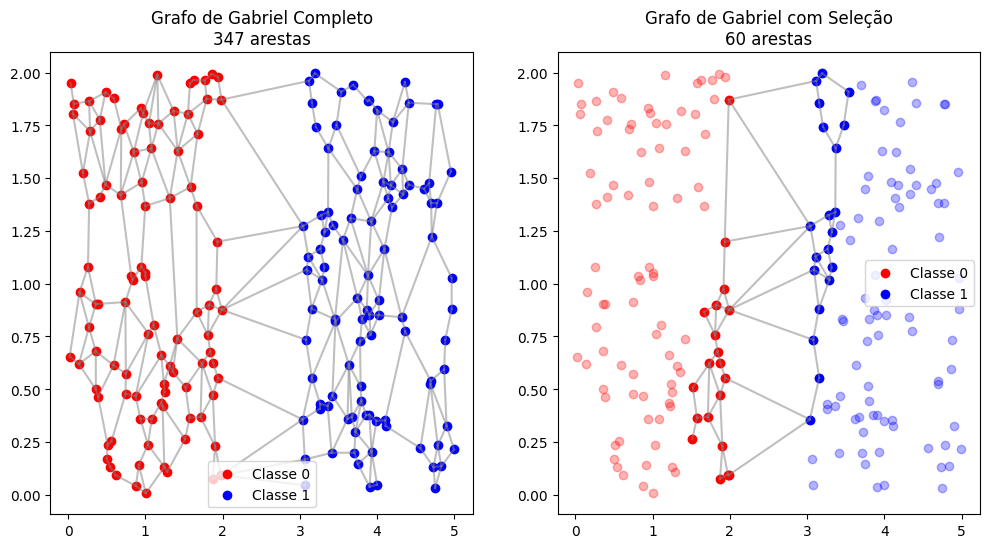

In [134]:
# Construir e plotar o Grafo de Gabriel sobre o dataset atual (x, y)
G1 = gg.GabrielGraph(device="cpu")
G1.build(x, y)
adj1 = G1.adj

G2 = gg.GabrielGraph(device="cpu")
G2.build(x_sel, y_sel)
adj2 = G2.adj

# Prepara as arestas uma vez (para contar e plotar)
edges = list(G1.edges())
num_edges = len(edges)

edges2 = list(G2.edges())
num_edges2 = len(edges2)  

# Plot 2D para os dois grafos
plt.figure(figsize=(12, 6))
# Pontos por classe
plt.subplot(1, 2, 1)
plt.scatter(x[y==-1][:,0], x[y==-1][:,1], c='red', label="Classe 0")
plt.scatter(x[y==1][:,0], x[y==1][:,1], c='blue', label="Classe 1")
# Arestas do grafo
for edge in edges:
    p1, p2 = edge
    plt.plot([x[p1,0], x[p2,0]], [x[p1,1], x[p2,1]], c='gray', alpha=0.5)   
plt.title(f'Grafo de Gabriel Completo\n{num_edges} arestas')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x_sel[y_sel==-1][:,0], x_sel[y_sel==-1][:,1], c='red', label="Classe 0")
plt.scatter(x_sel[y_sel==1][:,0], x_sel[y_sel==1][:,1], c='blue', label="Classe 1")

#Restante dos pontos nao selecionados coloridos por classe  
plt.scatter(x[y==-1][:,0], x[y==-1][:,1], c='red', alpha=0.3)
plt.scatter(x[y==1][:,0], x[y==1][:,1], c='blue', alpha=0.3)

# Arestas do grafo
for edge in edges2:
    p1, p2 = edge
    plt.plot([x_sel[p1,0], x_sel[p2,0]], [x_sel[p1,1], x_sel[p2,1]], c='gray', alpha=0.5)
plt.title(f'Grafo de Gabriel com Seleção\n{num_edges2} arestas')
plt.legend()
plt.show()  


In [135]:
#Identifica os vertices de suporte e calcula as coordenadas dos hiperpalanos
#perpendiculares a cada aresta de suporte que passam pelo ponto médio da aresta
support_edges = list(G.support_edges())
num_support_edges = len(support_edges)

hyperplanes = []
for (i, j) in support_edges:
    # Calcula o ponto médio da aresta
    mid_point = (G.X[i] + G.X[j]) / 2
    # O vetor normal ao hiperplano é perpendicular à aresta
    normal_vector = G.X[j] - G.X[i]
    hyperplanes.append((mid_point, normal_vector))

# Plota o Grafo de Gabriel com arestas de suporte e hiperplanos
plt.figure(figsize=(6, 6))
# Pontos por classe
plt.scatter(x[y == -1][:, 0], x[y == -1][:, 1], c="red", s=15, label="Classe -1", zorder=3)
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], c="blue", s=15, label="Classe 1", zorder=3)
# Arestas do Grafo de Gabriel
for i, j in edges:
    xi, yi = x[i, 0], x[i, 1]
    xj, yj = x[j, 0], x[j, 1]
    plt.plot([xi, xj], [yi, yj], color="gray", alpha=0.3, linewidth=0.7, zorder=1)  

# Arestas de suporte em destaque
for i, j in support_edges:
    xi, yi = x[i, 0], x[i, 1]
    xj, yj = x[j, 0], x[j, 1]
    plt.plot([xi, xj], [yi, yj], color="orange", alpha=0.8, linewidth=2, zorder=2)
# Hiperplanos perpendiculares às arestas de suporte
for (mid_point, normal_vector) in hyperplanes:
    # Define uma linha longa para o hiperplano
    length = 10  # comprimento arbitrário para visualização
    direction = np.array([-normal_vector[1], normal_vector[0]])  # vetor perpendicular
    direction = direction / np.linalg.norm(direction) * length  # normaliza e escala
    line_start = mid_point - direction / 2
    line_end = mid_point + direction / 2
    plt.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 
             color="grey", 
             linestyle="--", 
             linewidth=1,
              zorder=2,
              alpha=0.7)


#Enquadrar o conjunto de dados

plt.title(f"Gabriel Graph com Arestas de Suporte e Hiperplanos — N={x.shape[0]}, E_suporte={num_support_edges}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.xlim(min(x[:,0])-0.1, max(x[:,0])+.1)
plt.ylim(min(x[:,1])-0.1, max(x[:,1])+.1)
plt.show()

NameError: name 'G' is not defined